# Gradient

In [1]:
using PyPlot
using PyCall
using LinearAlgebra
using ImageFiltering

include("acoustic_solver.jl")
include("sinkhorn.jl")
include("adj_method.jl")

grad_sinkhorn (generic function with 1 method)

## Test Model

In [5]:
Nx = 51;
Ny = 51;
h = 0.02;

Fs = 250;
dt = 1/Fs
Nt = 501;
t = range(0, length=Nt, step=dt)

source = source_ricker(5, 0.2, t)
# plot(t,source); title("ricker source")
source_position = zeros(6,2)
for i = 1:6
#     source_position[i,:] = [3,(i-1)*20+1]
    source_position[i,:] = [(i-1)*10+1, 1]
end
source = repeat(source, 1, 6)

receiver_position = zeros(11,2)
for i = 1:11
#     receiver_position[i,:] = [1,(i-1)*5+1]
    receiver_position[i,:] = [(i-1)*5+1,51]
end

c = ones(Nx, Ny)
rho = ones(Nx, Ny)

c0 = ones(Nx, Ny)
rho0 = ones(Nx, Ny)
c0[20:30,20:30] .= 1.2;

c = imfilter(c0, Kernel.gaussian(50));

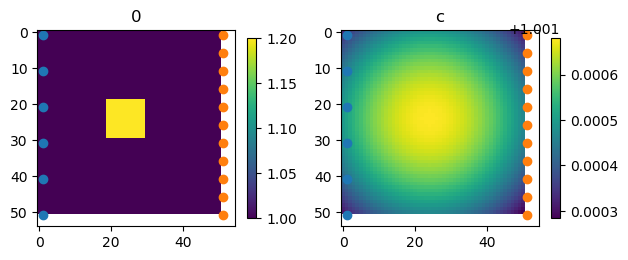

In [6]:
figure; 
subplot(121); imshow(c0); colorbar(shrink=0.4); title("0")
scatter(source_position[:,2], source_position[:,1])
scatter(receiver_position[:,2], receiver_position[:,1])
subplot(122); imshow(c); colorbar(shrink=0.4); title("c")
scatter(source_position[:,2], source_position[:,1])
scatter(receiver_position[:,2], receiver_position[:,1])
tight_layout()

## Forward modelling

In [7]:
@time data, u = multi_solver(c, rho, Nx, Ny, Nt, h, dt, source, source_position, receiver_position; pml_len=10, pml_coef=100);

@time data0, u0 = multi_solver(c0, rho0, Nx, Ny, Nt, h, dt, source, source_position, receiver_position; pml_len=10, pml_coef=100);

  9.920770 seconds (8.28 M allocations: 11.035 GiB, 19.77% gc time)
  7.500821 seconds (604.46 k allocations: 10.688 GiB, 25.02% gc time)


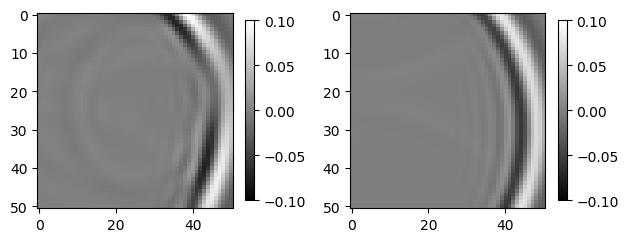

In [14]:
figure;
subplot(121); imshow(u0[:,:,300,4],cmap=ColorMap("gray")); colorbar(shrink=0.4); clim(-0.1,0.1)
subplot(122);imshow(u[:,:,300,4],cmap=ColorMap("gray")); colorbar(shrink=0.4); clim(-0.1,0.1)
tight_layout()

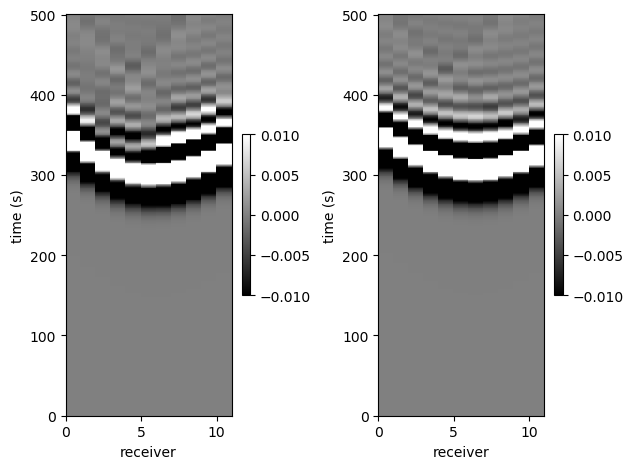

In [15]:
figure;
r_axis = 0:11
subplot(121); pcolor(data0[:,:,4],cmap=ColorMap("gray")); colorbar(shrink=0.4); clim([-0.01,0.01])
xlabel("receiver"); ylabel("time (s)")
subplot(122); pcolor(data[:,:,4],cmap=ColorMap("gray")); colorbar(shrink=0.4); clim([-0.01,0.01])
xlabel("receiver"); ylabel("time (s)")
tight_layout()

## L2 Gradient

In [16]:
@time vl = backward_solver(c, rho, Nx, Ny, Nt, h, dt, data-data0, source_position, receiver_position; pml_len=10, pml_coef=100);

  9.373334 seconds (3.45 M allocations: 10.810 GiB, 21.50% gc time)


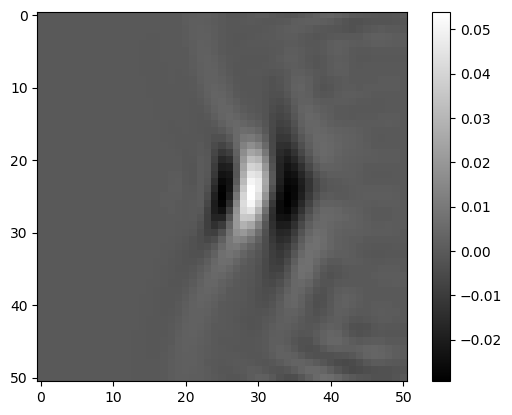

PyObject <matplotlib.colorbar.Colorbar object at 0x13e0ab4a8>

In [18]:
imshow(vl[:,:,300,3],cmap=ColorMap("gray")); colorbar()
# ; clim([-0.1,0.1])

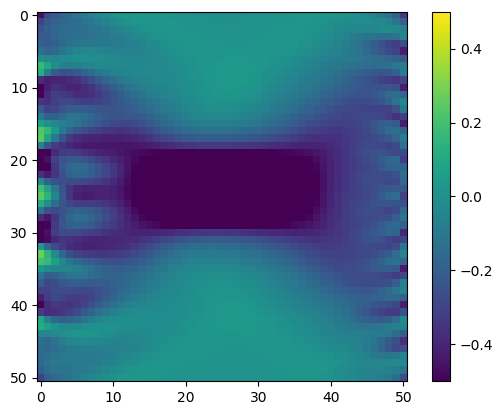

In [19]:
uu = 0 .* u;
uu[:,:,2:end-1,:] = (u[:,:,3:end,:] - 2*u[:,:,2:end-1,:] + u[:,:,1:end-2,:]) / (dt^2);
gradl = uu[:,:,end:-1:1,:].*vl
gradl = sum(gradl, dims=[3,4])
gradl = gradl[:,:,1,1]
gradl = gradl ./ (maximum(abs.(gradl)))
imshow(gradl); colorbar(); clim(-0.5,0.5)

In [20]:
function grad_l2(data, data0, c, rho, Nx, Ny, Nt, h, dt, source_position, receiver_position; pml_len=10, pml_coef=100);
#     input:
#     data1: received data
#     c1, rho1: 
    
    adj_source = data - data0
    
#     adjoint wavefield
    vl = backward_solver(c, rho, Nx, Ny, Nt, h, dt, adj_source, source_position, receiver_position; pml_len=pml_len, pml_coef=pml_coef);
    
    uu = 0 .* u;
    uu[:,:,2:end-1,:] = (u[:,:,3:end,:] - 2*u[:,:,2:end-1,:] + u[:,:,1:end-2,:]) / (dt^2);
    gradl = uu[:,:,end:-1:1,:].*vl
    gradl = sum(gradl, dims=[3,4])
    gradl = gradl[:,:,1,1]
    gradl = gradl ./ (maximum(abs.(gradl)))
    
    return gradl
end

grad_l2 (generic function with 2 methods)

In [21]:
@time gg = grad_l2(data, data0, c, rho, Nx, Ny, Nt, h, dt, source_position, receiver_position; pml_len=10, pml_coef=100);

  8.770593 seconds (1.67 M allocations: 11.328 GiB, 25.51% gc time)


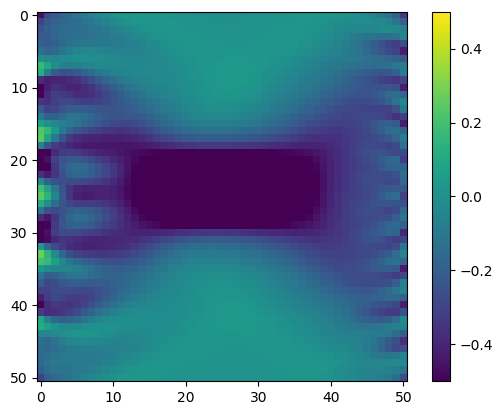

In [22]:
imshow(gradl); colorbar(); clim(-0.5,0.5)

## Compute gradient

In [23]:
f = data[:,4,4]
g = data0[:,4,4]

M = cost_func_1d(Nt)
T,a,d = sinkhorn_signal_1d(f, g, M; lambda=100, numItermax = 100, stopThr = 1e-6, verbose=true);

Iteration number: 16
Error: 7.841273364649254e-7
Iteration number: 22
Error: 8.629809876108769e-7


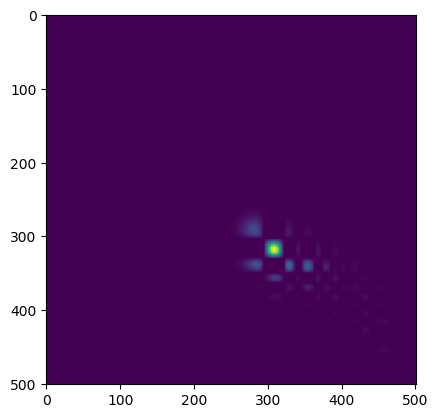

PyObject <matplotlib.image.AxesImage object at 0x143c4ccc0>

In [24]:
imshow(T)

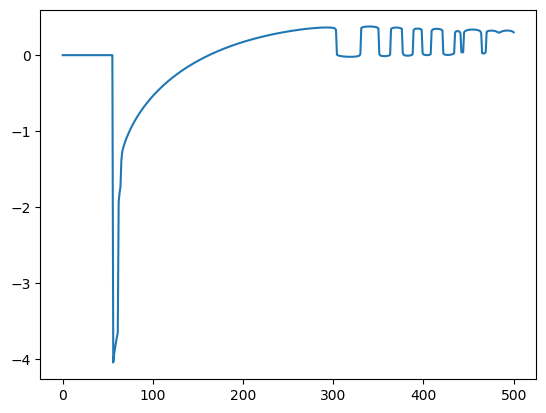

1-element Array{PyObject,1}:
 PyObject <matplotlib.lines.Line2D object at 0x13e1324a8>

In [25]:
plot(a)

In [26]:
adj_source = adj_source_sinkhorn(data, data0; lambda=1000, numItermax=10, stopThr = 1e-6, verbose=false);

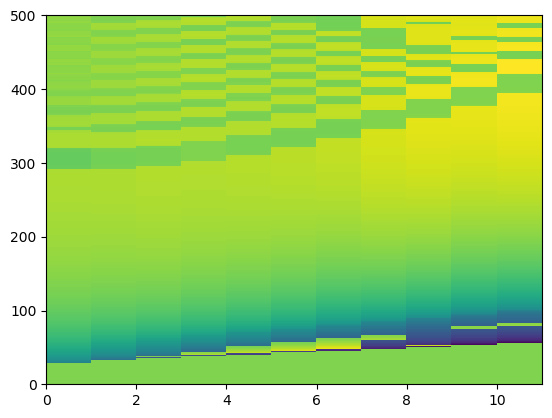

PyObject <matplotlib.collections.PolyCollection object at 0x143b720b8>

In [27]:
pcolor(adj_source[:,:,1])

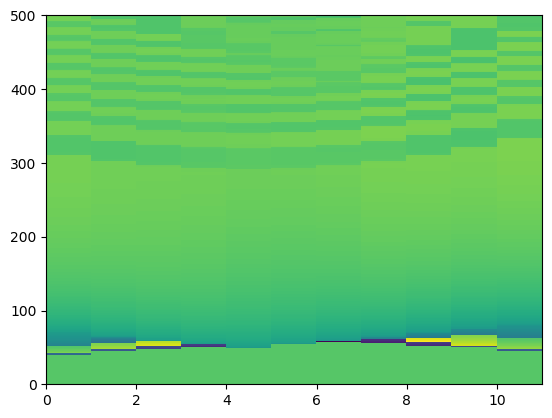

PyObject <matplotlib.collections.PolyCollection object at 0x13e593390>

In [28]:
pcolor(adj_source[:,:,3])

In [29]:
@time v = backward_solver(c, rho, Nx, Ny, Nt, h, dt, adj_source, source_position, receiver_position; pml_len=10, pml_coef=100);

  7.817088 seconds (604.46 k allocations: 10.689 GiB, 26.67% gc time)


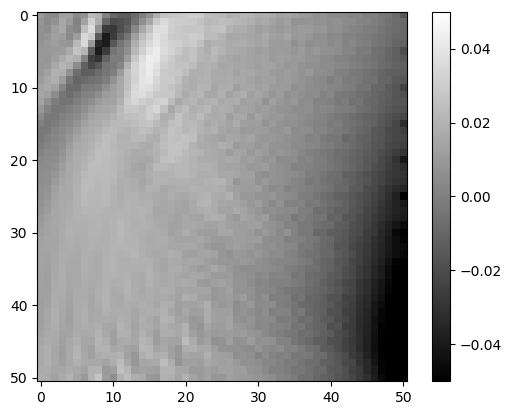

In [34]:
imshow(v[:,:,400,1],cmap=ColorMap("gray")); colorbar(); clim([-0.05,0.05])

In [35]:
uu = 0 .* u;
uu[:,:,2:end-1,:] = (u[:,:,3:end,:] - 2*u[:,:,2:end-1,:] + u[:,:,1:end-2,:]) / (dt^2);
grad = uu[:,:,end:-1:1,:].*v
grad = sum(grad, dims=[3,4])
grad = grad[:,:,1,1] ./ maximum(abs.(grad))

51×51 Array{Float64,2}:
  1.0         0.54167      0.403093   …  0.205256   0.281901    0.522885 
  0.527004    0.486557     0.399839      0.163744   0.225606    0.270271 
  0.233138    0.345762     0.334636      0.0780478  0.0720734   0.037227 
  0.0485216   0.175314     0.229977      0.129398   0.0538318  -0.0960154
 -0.0351803   0.0546387    0.131285      0.246562   0.243088    0.147821 
 -0.0522642  -0.00585372   0.0378405  …  0.232617   0.281642    0.510055 
 -0.0894921  -0.113133    -0.102085      0.150538   0.189975    0.216531 
 -0.24895    -0.252062    -0.165979      0.0792306  0.036195   -0.0305968
 -0.268628   -0.0759437    0.0558408     0.137181   0.0319152  -0.135319 
  0.271422    0.365296     0.315849      0.222396   0.212316    0.125163 
  0.98899     0.495271     0.350373   …  0.192494   0.253578    0.506748 
  0.459637    0.427192     0.328353      0.128847   0.171486    0.206402 
  0.119047    0.260734     0.268231      0.0863618  0.0388427  -0.042146 
  ⋮           

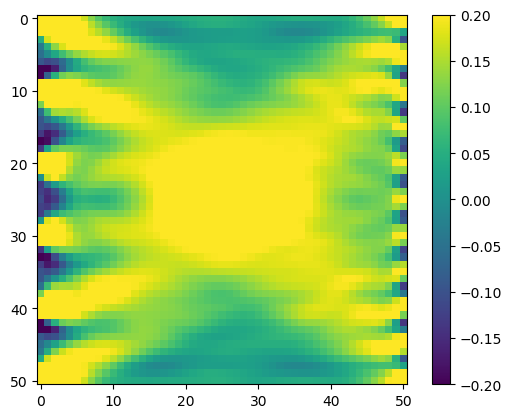

In [40]:
imshow(grad); colorbar(); clim(-0.2,0.2)

In [69]:
function grad_sinkhorn(data, data0, c, rho, Nx, Ny, Nt, h, dt, source_position, receiver_position; pml_len=10, pml_coef=100, lambda=1000, numItermax=10, stopThr = 1e-6)
    
    adj_source = adj_source_sinkhorn(data, data0; lambda=lambda, numItermax=numItermax, stopThr=stopThr, verbose=false);
    
#     adjoint wavefield
    v = backward_solver(c, rho, Nx, Ny, Nt, h, dt, adj_source, source_position, receiver_position; pml_len=pml_len, pml_coef=pml_coef);
    
    uu = 0 .* u;
    uu[:,:,2:end-1,:] = (u[:,:,3:end,:] - 2*u[:,:,2:end-1,:] + u[:,:,1:end-2,:]) / (dt^2);
    grad = uu[:,:,end:-1:1,:].*v
    grad = sum(grad, dims=[3,4])
    grad = grad[:,:,1,1] ./ maximum(abs.(grad))
    
    return grad
end

grad_sinkhorn (generic function with 1 method)

In [79]:
@time gg1 = grad_sinkhorn(data, data0, c, rho, Nx, Ny, Nt, h, dt, source_position, receiver_position; pml_len=10, pml_coef=10, lambda=500, numItermax=10, stopThr = 1e-6);

 52.145129 seconds (1.24 M allocations: 79.966 GiB, 22.63% gc time)


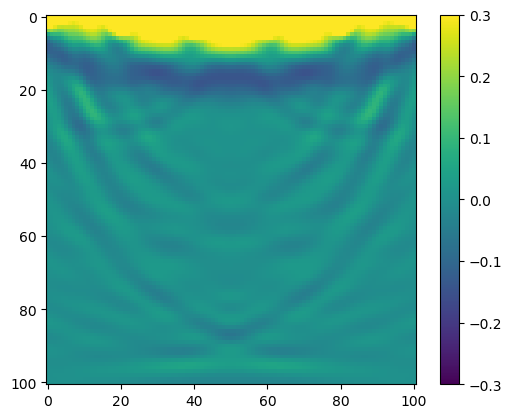

PyObject <matplotlib.colorbar.Colorbar object at 0x17f1ed1d0>

In [80]:
imshow(gg1); clim(-0.3,0.3); colorbar()

## Derivative of Sinkhorn distance

In [20]:
ind_source = 4;

In [21]:
M = cost_matrix_2d(Nt,21);

In [ ]:
@time T, a, d = sinkhorn_signal_2d(data1[:,:,ind_source], data2[:,:,ind_source], M; lambda=0.001, numItermax = 10, stopThr = 1e-6, verbose=true);

Iteration number: 10
Error: 

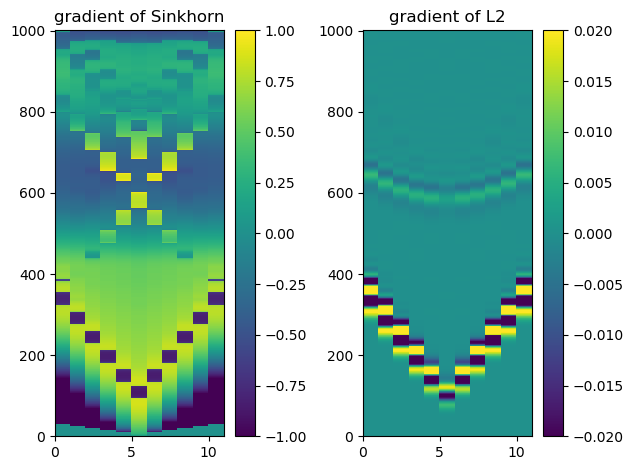

In [72]:
figure;
a0 = reshape(a, Nt, 11) ./ maximum(a)
subplot(121); pcolor(a0); colorbar(); clim([-1,1]); title("gradient of Sinkhorn")
subplot(122); pcolor(data2 - data1); colorbar(); clim(-0.02,0.02); title("gradient of L2")
tight_layout()

## Backward Propagation

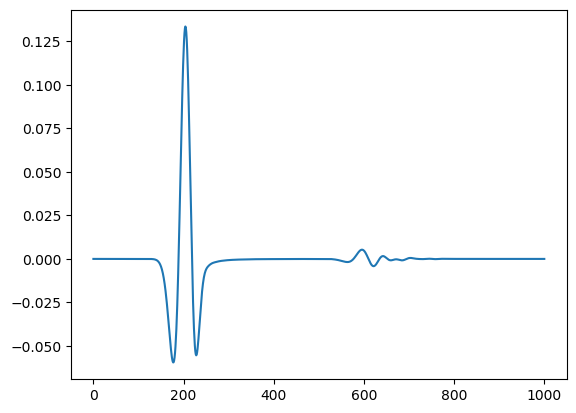

1-element Array{PyObject,1}:
 PyObject <matplotlib.lines.Line2D object at 0x14a43a748>

In [91]:
plot(data2[:,4])

In [113]:
adj_source = data2 - data1;
adj_source = adj_source ./ maximum(abs.(adj_source))
@time v_l2 = backward_solver(c1, rho1, Nx, Ny, Nt, h, dt, adj_source, source_position, receiver_position; pml_len=10, pml_coef=100);

  6.913311 seconds (201.32 k allocations: 10.472 GiB, 21.90% gc time)


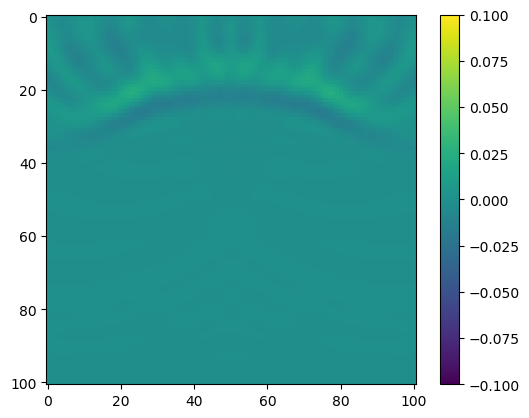

In [114]:
imshow(v_l2[:,:,500,1]); colorbar(); clim(-0.1,0.1)

In [98]:
adj_source = reshape(a, Nt, 11)
adj_source = adj_source ./ maximum(abs.(adj_source))
@time v_s = backward_solver(c1, rho1, Nx, Ny, Nt, h, dt, adj_source, source_position, receiver_position; pml_len=10, pml_coef=100);

  6.992974 seconds (201.26 k allocations: 10.472 GiB, 21.71% gc time)


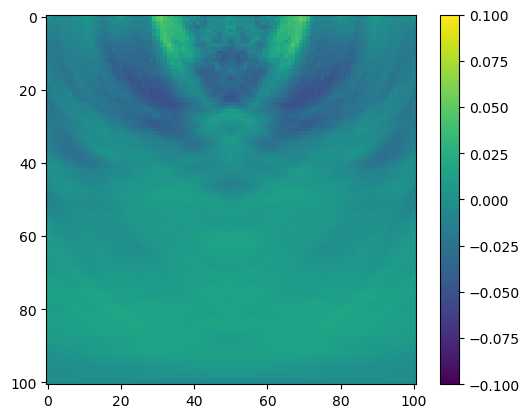

In [112]:
imshow(v_s[:,:,500,1]); colorbar(); clim(-0.1,0.1)

# Gradient by adjoint method

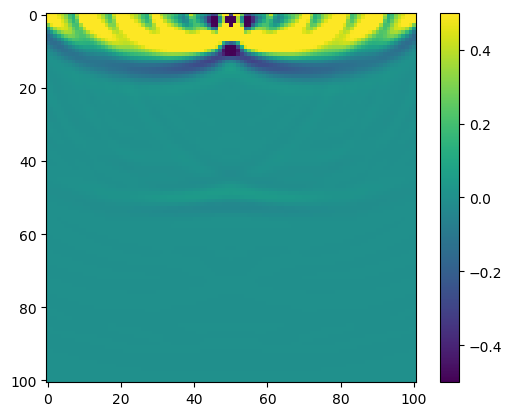

In [126]:
grad_l = p2[:,:,end:-1:1].*v_l2
grad_l = sum(grad_l, dims=3)
grad_l = grad_l[:,:,1,1]
imshow(grad_l); colorbar(); clim(-0.5,0.5)

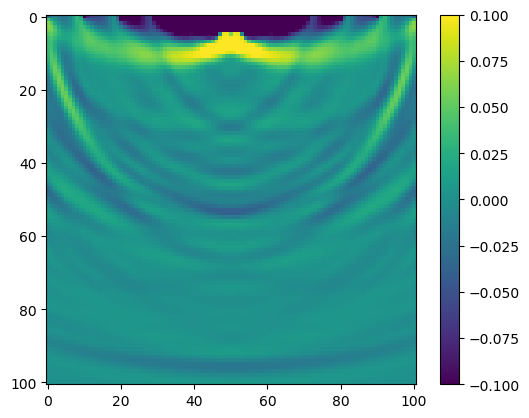

In [129]:
grad_s = p2[:,:,end:-1:1].*v_s
grad_s = sum(grad_s, dims=3)
grad_s = grad_s[:,:,1,1]
imshow(grad_s); colorbar(); clim(-0.1,0.1)